In [3]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Loading Data
df = pd.read_csv("/content/bank_data.csv")
print("Rows:", len(df))
df.head()   # Quick overview

Rows: 4521


,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


| Column    | Meaning                                                                  |
| --------- | ------------------------------------------------------------------------ |
| age       | Customer age                                                             |
| job       | Type of job                                                              |
| marital   | Marital status                                                           |
| education | Education level                                                          |
| balance   | Average yearly balance                                                   |
| contact   | Communication type                                                       |
| campaign  | Number of contacts during campaign                                       |
| duration  | Call duration (seconds)                                                  |
| poutcome  | Outcome of previous campaign                                             |
| y         | Target variable — whether they subscribed to a term deposit (“yes”/“no”) |


(Those are only important columns)

In [5]:
# Basic Cleaning
df.columns = df.columns.str.strip().str.lower()
df["y"] = df["y"].map({"yes": 1, "no": 0})    # Convert target to binary
print(df.isna().sum())

unnamed: 0    0
age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
dtype: int64


There is no Null values, so no need to clean from those

In [6]:
# Quick Stats
print(df.describe())
print("Response rate:", df["y"].mean()*100, "%")

        unnamed: 0          age       balance          day     duration  \
count  4521.000000  4521.000000   4521.000000  4521.000000  4521.000000   
mean   2260.000000    41.170095   1422.657819    15.915284   263.961292   
std    1305.244613    10.576211   3009.638142     8.247667   259.856633   
min       0.000000    19.000000  -3313.000000     1.000000     4.000000   
25%    1130.000000    33.000000     69.000000     9.000000   104.000000   
50%    2260.000000    39.000000    444.000000    16.000000   185.000000   
75%    3390.000000    49.000000   1480.000000    21.000000   329.000000   
max    4520.000000    87.000000  71188.000000    31.000000  3025.000000   

          campaign        pdays     previous            y  
count  4521.000000  4521.000000  4521.000000  4521.000000  
mean      2.793630    39.766645     0.542579     0.115240  
std       3.109807   100.121124     1.693562     0.319347  
min       1.000000    -1.000000     0.000000     0.000000  
25%       1.000000    -1

1. Dataset contains 4,521 marketing contacts with an overall response rate of 11.5%.
2. The average yearly balance is around €1,423, but the standard deviation (3,009) is more than twice the mean, suggesting very high variability - some customers have large savings, others have debts (negative balances).

Early conclusion: customer base is financially diverse - segmentation by balance could reveal very different response patterns.

3. On average, a client was contacted about 2-3 times per campaign, but some received up to 50 calls - potential over-contacting.
4. The average customer age is 41 years (range 19-87), indicating a primarily middle-aged client base.

Early conclusion: These initial findings suggest strong customer heterogeneity - later analysis will focus on how job, education, and balance affect response rate.


In [7]:
# EDA: Campaign performance
job_resp = df.groupby("job")["y"].mean().sort_values(ascending=False)*100
edu_resp = df.groupby("education")["y"].mean().sort_values(ascending=False)*100
bal_resp = df.groupby("y")["balance"].mean()

print(job_resp)
print(edu_resp)
print(bal_resp)

job
retired          23.478261
student          22.619048
unknown          18.421053
management       13.519092
housemaid        12.500000
admin.           12.133891
self-employed    10.928962
technician       10.807292
unemployed       10.156250
services          9.112710
entrepreneur      8.928571
blue-collar       7.293869
Name: y, dtype: float64
education
tertiary     14.296296
secondary    10.624458
unknown      10.160428
primary       9.439528
Name: y, dtype: float64
y
0    1403.211750
1    1571.955854
Name: balance, dtype: float64


Response Rate by Job Type Analysis:
1. The retired and student segments have twice the average success rate (23%) compared to the overall average of 11.5%.
2. Blue-collar and entrepreneurial customers are the least responsive (below 9%).

Conclusion: The campaign performs best among customers with more available time (retired, students) or possibly more stable savings behavior.
Low response among blue-collar and entrepreneurial clients may indicate that the offer isn’t aligned with their financial priorities or timing.

Response Rate by Education Analysis:
1. Customers with higher education (tertiary) are more likely to subscribe.
2. This might reflect greater financial literacy or trust in long-term investments.
3. Lower-educated groups are less responsive - could indicate lower perceived relevance or financial capacity.

Average Balance by Response Analysis:
1. Customers who subscribed have €170 higher average balances - suggesting wealthier customers are slightly more inclined to invest in term deposits.

Conclusion: This is subtle but important, it confirms the economic logic that those with more liquidity are more open to deposit products

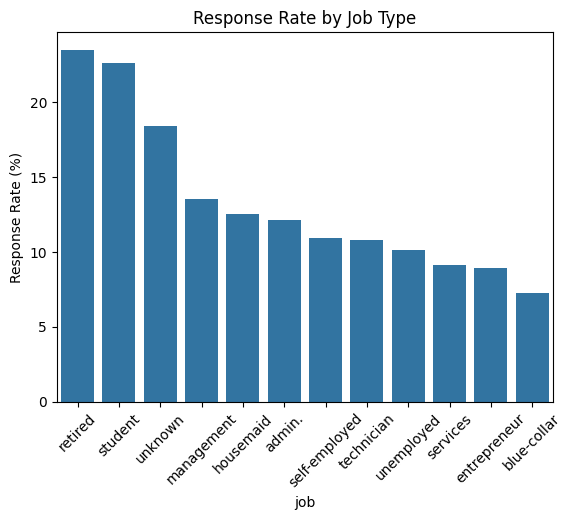

In [8]:
# Visualization
sns.barplot(x=job_resp.index, y=job_resp.values)
plt.xticks(rotation=45)
plt.title("Response Rate by Job Type")
plt.ylabel("Response Rate (%)")
plt.show()

In [9]:
# Export summaries for Power BI
job_summary = df.groupby("job").agg(
    response_rate=("y", "mean"),
    avg_balance=("balance", "mean"),
    total_customers=("y", "count")
).reset_index()

edu_summary = df.groupby("education").agg(
    response_rate=("y", "mean"),
    avg_balance=("balance", "mean"),
    total_customers=("y", "count")
).reset_index()

job_summary.to_csv("job_summary.csv", index=False)
edu_summary.to_csv("edu_summary.csv", index=False)

print("Summary files exported. Ready for Power BI import.")

Summary files exported. Ready for Power BI import.
